# 第六章 嵌入适配器 Embedding Adaptors

## 目录
- [ 6.1 -Embedding Adaptors原理及准备工作](#61-embedding-adaptors原理及准备工作)
- [ 6.2 - Creating a dataset（创建数据集）](#62-creating-a-dataset创建数据集)
- [ 6.3 - Setting up the model（设置模型）](#63-setting-up-the-model设置模型)
- [ 6.4 - 总结](#64-总结)

在这一章中，我们将学习使用Embedding Adaptors(嵌入适配器)进行查询结果的增强。

## 6.1  Embedding Adaptors原理及准备工作

![Embedding Adapter.png](./images/Embedding%20Adapter.png)

我们通过图片了解 Embedding Adaptors（嵌入适配器）的工作原理：

在一个系统中，用户通过应用程序(App)提交一个查询（例如“Revenue Growth”），查询会被发送到大型语言模型（LLM）中。而在检索部分，嵌入模型会根据查询生成嵌入向量，嵌入适配器会对这些嵌入进行进一步处理或转换。最后，系统会基于嵌入向量检索相关文档（例如“Annual Income...”），最终，LLM会使用这些信息来生成答案。

Embedding Adaptors（嵌入适配器）是一种改变查询的嵌入，直接为了产生更好的检索结果。

我们在检索系统中插入一个额外的阶段，称为嵌入适配器。这发生在嵌入模型之后，但在我们得到最相关的结果之前。

首先，加载我们需要的辅助函数，为了有效地训练模型，这次我们需要使用`torch`。

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
import umap
from tqdm import tqdm
import torch
import warnings

# 忽略 FutureWarning 类型的警告
warnings.filterwarnings("ignore", category=FutureWarning)

生成我们的嵌入函数并将所有内容加载到`chroma_collection`集合中。

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='./data/2024年北京市政府工作报告.pdf', 
                                collection_name='beijing_annual_report_2024', 
                                embedding_function=embedding_function,
                                langcode='zh')  # 注意中文文档将langcode改为'zh'
chroma_collection.count()

1028

投射我们的嵌入数据。

In [3]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0, n_jobs=1).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1028/1028 [00:08<00:00, 128.11it/s]


与以前相同，配置`OPENAI_API_KEY`。

In [4]:
# 使用代理可能出现网络问题，将以下端口号1080全部替换成自己的vpn的端口号
import os
# os.environ['HTTPS_PROXY']='http://127.0.0.1:1080'
# os.environ["HTTP_PROXY"]='http://127.0.0.1:1080'
import openai
from openai import OpenAI
from dotenv import load_dotenv, find_dotenv

loaded = load_dotenv(find_dotenv(), override=True)
# 从环境变量中获取 OpenAI API Key 或者直接赋值
API_KEY = os.getenv("API_KEY")

# 如果您使用的是官方 API，就直接用 https://api.siliconflow.cn/v1 就行。
BASE_URL = "https://api.siliconflow.cn/v1"

openai_client = OpenAI(api_key=API_KEY, base_url=BASE_URL, max_retries=3)

## 6.2 Creating a dataset（创建数据集）

与以前相同（增加不同的系统指示）。

In [5]:
def generate_queries(model="Qwen/Qwen3-8B"):

    extra_body = {}
    if "Qwen3" in model:
        extra_body={
            "enable_thinking": False
        }
    
    messages = [
        {
            "role": "system",
            # 系统角色消息，它指示模型扮演一个有帮助的、专业的政府年度报告研究助手角色。
            # 提供的内容是一个明确的任务描述，要求模型提出10到15个短问题，
            # 这些问题在分析年度报告时非常重要。
            # 这个指示还特别要求模型不要输出复合问题，即包含多个句子或连接词的问题。
            # 同时要求每个问题单独一行，行与行之间用换行符分隔。
            "content": "You are a helpful and expert financial research assistant. You help users analyze government work reports to better understand the government. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
            "Use Chinese"
        },
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        extra_body=extra_body
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

使用LLM进行生成我们的15个问题。

In [6]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

1. 报告中提到的经济增长数据具体包括哪些指标？  
2. 政府在本年度实施了哪些重要的财政政策？  
3. 报告中有哪些关于社会民生方面的投入和成果？  
4. 本年度政府在科技创新领域有哪些重要举措？  
5. 报告中是否提到了环境保护和可持续发展方面的进展？  
6. 政府在基础设施建设方面有哪些投资计划和完成情况？  
7. 报告中涉及的教育事业发展情况如何？  
8. 本年度政府在医疗卫生领域的投入和成效是什么？  
9. 报告中提到的就业情况有哪些具体数据？  
10. 政府在扶贫攻坚方面有哪些新举措和成果？  
11. 报告中是否提到了金融监管和风险防控方面的措施？  
12. 本年度政府在文化体育事业方面的投入情况如何？  
13. 报告中有哪些关于国防和军队建设的说明？  
14. 政府在应对自然灾害和突发事件方面有哪些措施？  
15. 报告中提到的财政收支情况是否公开透明？


指定返回每个查询的前10个结果，并且要求结果包括相关文档和嵌入向量。

In [7]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

执行这段代码后，`retrieved_documents`中将包含每个查询问题检索到的文档列表。

提示模型系统（给定的陈述是否与给定的相关查询）。

In [8]:
def evaluate_results(query, statement, model="Qwen/Qwen3-8B"):

    extra_body = {}
    if "Qwen3" in model:
        extra_body={
            "enable_thinking": False
        }
    
    messages = [
    {
        "role": "system",
        # 指示模型扮演一个有用的财务研究助手角色，
        # 并要求模型评估给定查询与声明的相关性，只输出"yes"或"no"。
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]
    # 使用OpenAI的chat API发送请求，传递模型名称、消息列表和最大令牌数。
    # 最大令牌数设置为1，因为期望的输出只有"yes"或"no"。
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1,
        extra_body=extra_body
    )
    # 从响应中提取内容，即模型的输出。
    content = response.choices[0].message.content
    # 如果内容为"yes"，返回1，表示声明与查询相关；
    # 否则返回-1，表示声明与查询不相关。
    if content == "yes":
        return 1
    return -1

从检索结果中提取嵌入向量，然后为生成的查询计算嵌入向量。

In [9]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

`adapter_query_embeddings`、`adapter_doc_embeddings`和`adapter_labels`三个空列表将被用于存储适配器查询的嵌入向量、文档的嵌入向量，以及对应的标签。

In [10]:
adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

遍历生成的查询和每个查询检索到的文档，计算查询和文档的嵌入向量，并使用`evaluate_results`函数评估了每对查询和文档的相关性。对于每个查询和文档的组合，将查询的嵌入向量、文档的嵌入向量和评估结果（作为标签）分别添加到`adapter_query_embeddings`、`adapter_doc_embeddings`和`adapter_labels`列表中。

因为使用免费的openAIAPI会出现调用限制等，我们这里使用`time.sleep()`进行减缓请求速度，从而保证因请求过快而被API服务限流。

这里也可以使用除openAIAPI以外的API服务。

In [11]:
import time
from tqdm import tqdm

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

        time.sleep(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:35<00:00, 18.37s/it]


查看新的数据集的长度。

In [12]:
len(adapter_labels)

150

得到150个，这是15个查询和10个结果，并且每一个都标有相关性。

使用我们的`torch`进行训练我们的嵌入适配器。

将我们的数据集转换成`torch tensor`类型数据集，并全部装进`torch`。

我们使用这些`Tensor`类型数据训练一个分类模型，该模型预测给定查询和文档对是否相关（即标签为 $1$ 表示相关，$-1$ 表示不相关）。

In [13]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels),1))

创建了一个数据集，数据集封装查询嵌入向量、文档嵌入向量和标签的张量。

In [14]:
dataset = torch.utils.data.TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

## 6.3 Setting up the model（设置模型）

设置我们的嵌入适配器模型。

使用适配器矩阵来更新查询嵌入向量，并计算更新后的查询嵌入向量与文档嵌入向量之间的余弦相似度。

In [15]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

使用均方误差损失来评估模型输出与真实标签之间差异。

In [16]:
def mse_loss(query_embedding, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

初始化一个适配器矩阵，这个矩阵将用于更新查询嵌入向量或者在模型中执行其他转换任务。

In [17]:
mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

建立训练循环，通过最小化损失函数来优化适配器矩阵。

In [18]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)

        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

        loss.backward()
        with torch.no_grad():
            adapter_matrix -= 0.01 * adapter_matrix.grad
            adapter_matrix.grad.zero_()

  0%|                                                                                                                                                       | 0/100 [00:00<?, ?it/s]E:\LearningDisk\Learning_Projects\MyPythonProjects\llm-cookbook\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.19it/s]


打印最佳损失值。

In [19]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.5020642876625061


如果模型用Qwen3，最佳损失值约为0.50，如果用GPT，最佳损失值约为0.30。

接下来，我们看看适配器矩阵是如何影响我们的查询向量的。

使用`NumPy`的矩阵乘法函数计算`best_matrix`（一个`NumPy`数组）和`test_vector`（一个`PyTorch`张量）之间的矩阵乘法将结果转换为`NumPy`数组。

In [20]:
test_vector = torch.ones((mat_size,1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

C:\Users\hurui\AppData\Local\Temp\ipykernel_30128\3796843811.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  scaled_vector = np.matmul(best_matrix, test_vector).numpy()


将上一步保存在`scaled_vector`数组进行绘制条形图。

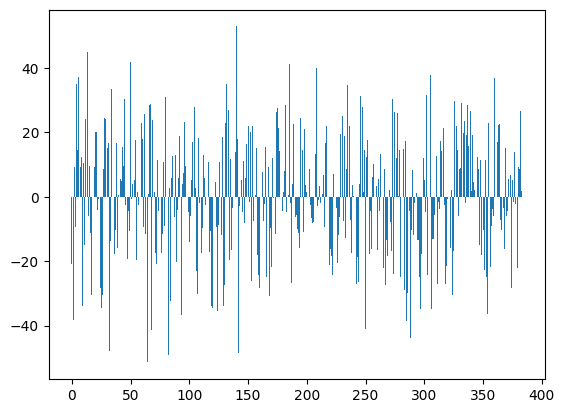

In [21]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()


在这里可以看到我们的每个维度仅由1组成的测试向量被拉伸和挤压，有些已经拉长了很多，而另一些则几乎为零。

所以这意味着我们的嵌入适配器基本上已经确定与这些维度相关性。

使用`embedding_function`函数为生成的查询计算嵌入向量。

使用之前获得的最佳适配器矩阵（`best_matrix`）来调整查询嵌入向量，产生`adapted_query_embeddings`。

使用`umap`通过`project_embeddings`函数将原始查询嵌入向量和调整后的查询嵌入向量投影。

In [22]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 230.77it/s]


绘制原始查询嵌入向量、调整后的查询嵌入向量以及数据集嵌入向量的分布图。

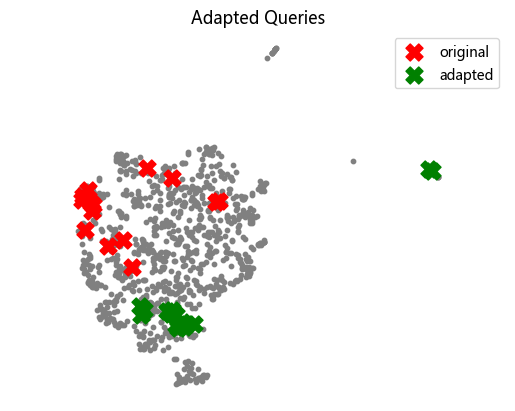

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置全局字体为微软雅黑，显示中文
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend();

红色`X`标记表示原始查询嵌入向量的分布，绿色`X`标记表示调整后的查询嵌入向量的分布。

可以直接获得关于适配器矩阵调整效果的直观感受，我们的原始查询非常分散，但是我们的调整后的查询更接近某些特定的文档嵌入向量。

## 6.4 总结

通过本次使用Embedding Adaptors进行自定义查询嵌入向量的处理，从而达到查询结果的增强效果。